# Selecting Praesepe members, compiling data and fitting a gyrochronology relation

This notebook reproduces figures in the paper.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from tqdm import tqdm
from astropy.io import fits

plotpar = {'axes.labelsize': 40,
           'font.size': 30,
           'legend.fontsize': 30,
           'xtick.labelsize': 40,
           'ytick.labelsize': 40,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Load the Douglas Praesepe rotation period catalog.

In [217]:
douglas = pd.read_csv("../../data/praesepe_douglas.csv", skiprows=89)
douglas.head()

,Name,EPIC,Mass,r'mag,Kmag,Prot1,Pw1,Q1,Clean?,Sig,...,SmAmp,P,Kpmag,PrCat,PCat,All,2M,Simbad,_RA,_DE
0,KW547,211898181,1.05,11.65,9.70,,,2,,,...,,,11.68,0,0,All,2M,Simbad,130.157851,18.700121
1,A 448,211845572,0.15,18.59,14.57,,,2,,,...,,,17.36,0,0,All,2M,Simbad,129.143078,17.957611
2,KW548,212004731,0.80,11.81,10.59,3.96,0.1085,0,N,0.00838,...,0.02363,2,11.79,0,0,All,2M,Simbad,130.815494,20.333748
3,JC201,211930461,0.73,13.49,10.76,14.59,0.8391,0,Y,0.00816,...,0.38429,2,13.49,0,1,All,2M,Simbad,130.088905,19.181773
4,,212094548,0.16,19.52,14.25,6.60,0.0089,1,N,0.00521,...,0.77485,2,18.71,0,1,All,2M,Simbad,130.281121,21.915739


Format the data: convert periods from strings to floats and get rid of spaces in the dataframe

In [4]:
periods = []
for p in douglas.Prot1.values:
    if p == "     ":
        periods.append(0.)
    else:
        periods.append(float(p))
douglas["period"] = np.array(periods)

Load the Bedell Gaia-K2 crossmatch (downloaded from gaia-kepler.fun) and ensmallen it so it's a managable size.

In [5]:
with fits.open('../../data/k2_dr2_1arcsec.fits') as data:
    bedell = pd.DataFrame(data[1].data)
bedell.keys()

c5_mask = bedell.k2_campaign_str.values == "5"
c5 = pd.DataFrame(dict({"source_id": bedell.source_id.values[c5_mask], 
                        "EPIC": bedell.epic_number.values[c5_mask], 
                        "ra": bedell.ra.values[c5_mask], 
                        "dec": bedell.dec.values[c5_mask], 
                        "G": bedell.phot_g_mean_mag.values[c5_mask],
                        "bp": bedell.phot_bp_mean_mag.values[c5_mask],
                        "rp": bedell.phot_rp_mean_mag.values[c5_mask],
                        "parallax": bedell.parallax.values[c5_mask],
                        "parallax_err": bedell.parallax_error.values[c5_mask],
                       }))

Text(0,0.5,'Dec')

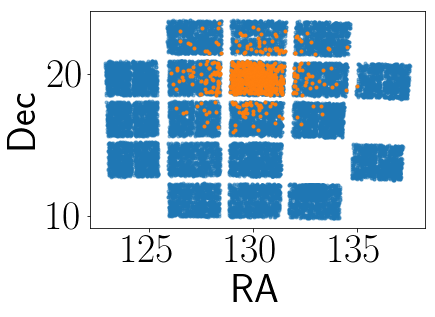

In [6]:
plt.plot(c5.ra, c5.dec, ".", alpha=.5)
plt.plot(douglas._RA, douglas._DE, ".")
plt.xlabel("RA")
plt.ylabel("Dec")

Just plot the crossmatched stars.

In [7]:
df = pd.merge(c5, douglas, on="EPIC", how="inner")
df.drop_duplicates("EPIC", inplace=True)
print(np.shape(c5), np.shape(douglas), np.shape(df))

(27500, 9) (794, 29) (757, 37)


Text(0,0.5,'Dec')

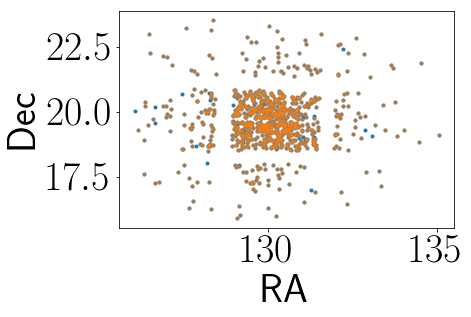

In [8]:
plt.plot(douglas._RA, douglas._DE, ".")
plt.plot(df.ra, df.dec, ".", alpha=.5)
plt.xlabel("RA")
plt.ylabel("Dec")

In [9]:
df.keys()

Index(['EPIC', 'G', 'bp', 'dec', 'parallax', 'parallax_err', 'ra', 'rp',
       'source_id', 'Name', 'Mass', 'r'mag', 'Kmag', 'Prot1', 'Pw1', 'Q1',
       'Clean?', 'Sig', 'Prot2', 'Pw2', 'Q2', 'MP?', 'SE?', 'Bl?', 'Bin?',
       'RawAmp', 'SmAmp', 'P', 'Kpmag', 'PrCat', 'PCat', 'All', '2M', 'Simbad',
       '_RA', '_DE', 'period'],
      dtype='object')

/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


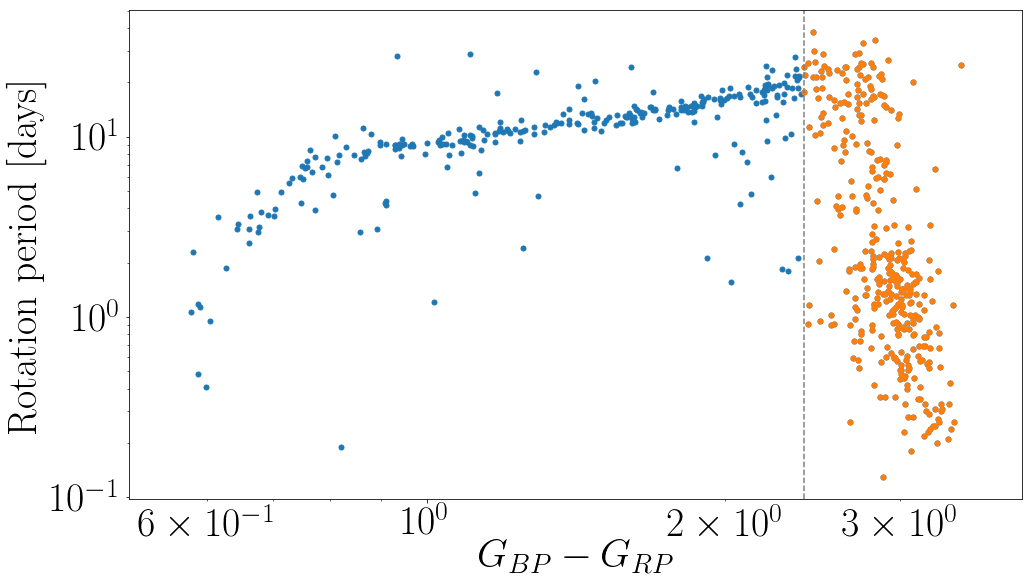

In [10]:
gaia_color = df.bp - df.rp
Mdwarf_cut = 2.4
color_mask = gaia_color < Mdwarf_cut

plt.figure(figsize=(16, 9))
plt.loglog(gaia_color, df.period, ".", ms=10)
plt.loglog(gaia_color[~color_mask], df.period[~color_mask], ".", color="tab:orange", ms=10)
plt.xlabel("$G_{BP} - G_{RP}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")
plt.xlim(10**-.3, 10**.6)
plt.axvline(Mdwarf_cut, color=".5", ls="--")
plt.savefig("../praesepe.pdf")

Remove outliers using sigma clipping.

/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log10
/Users/ruthangus/anaconda/lib/python3.5/site-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


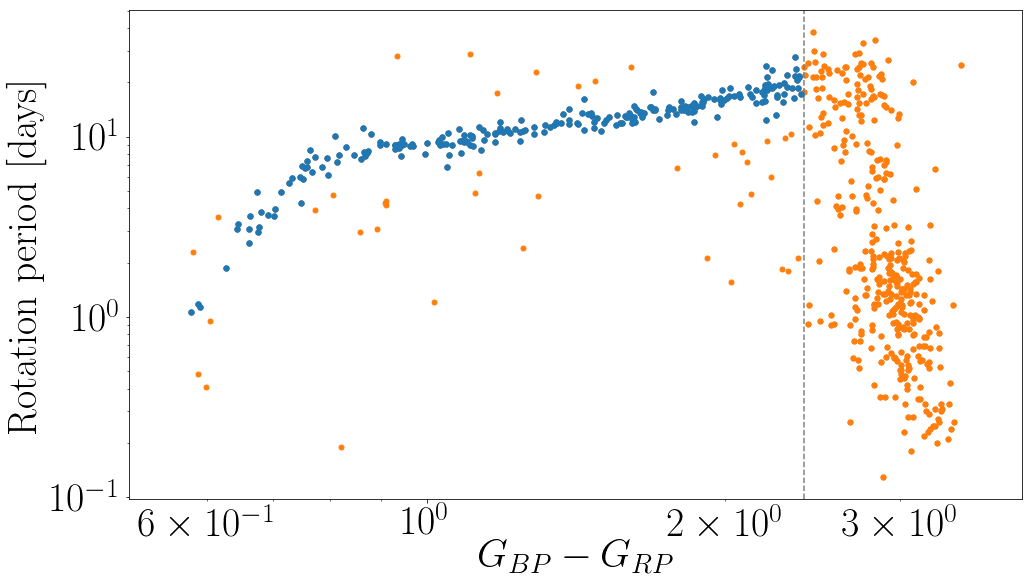

In [155]:
def sigma_clip(x, y):
    finite_mask = np.isfinite(x) * np.isfinite(y)
    x, y = x[finite_mask], y[finite_mask]
    new_x, new_y = x*1, y*1
    
    for i in range(10):
        A = np.vander(new_x, 6)
        ATA = np.dot(A.T, A)
        pr = np.linalg.solve(ATA, np.dot(A.T, new_y))
        y_pred = np.polyval(pr, new_x)
        sigma = np.std(np.abs(new_y - y_pred))
        outlier_mask = np.abs(new_y - y_pred) < 4.5*sigma
        new_x, new_y = new_x[outlier_mask], new_y[outlier_mask]
    
    return new_x, new_y

x_clipped, y_clipped = sigma_clip(np.log10(gaia_color[m_mask]), np.log10(df.period[m_mask]))

plt.figure(figsize=(16, 9))
plt.loglog(gaia_color, df.period, ".", ms=10, color="tab:orange")
plt.loglog(gaia_color[~color_mask], df.period[~color_mask], ".", color="tab:orange", ms=10)
plt.xlabel("$G_{BP} - G_{RP}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")
plt.xlim(10**-.3, 10**.6)
plt.axvline(Mdwarf_cut, color=".5", ls="--")
plt.loglog(10**x_clipped, 10**y_clipped, ".", ms=11)

Now fit a model

In [151]:
praesepe_age = 625
sun_age, sun_prot, sun_color = np.array([4.56]), np.array([26]), np.array([.82])

x = np.concatenate((x_clipped, np.log10(sun_color)))
y = np.concatenate((y_clipped, np.log10(sun_prot)))
z = np.concatenate((np.log10(np.ones_like(x_clipped)*praesepe_age), np.log10(sun_age)))

finite_mask = np.isfinite(x) * np.isfinite(y) * np.isfinite(z)
x, y, z = x[finite_mask], y[finite_mask], z[finite_mask]

sigma = z*.1  # 10% uncertainties
sigma[-1] = sun_age * .01 # 1% uncertainty for the Sun 

AT = np.vstack((np.ones(len(x)), x, x**2, x**3, x**4, z))
ATA = np.dot(AT, AT.T)
p = np.linalg.solve(ATA, np.dot(AT, y))
p

array([  1.68977743,   0.6183025 ,  -4.452133  ,  31.02877576,
       -47.76497323,  -0.25182579])

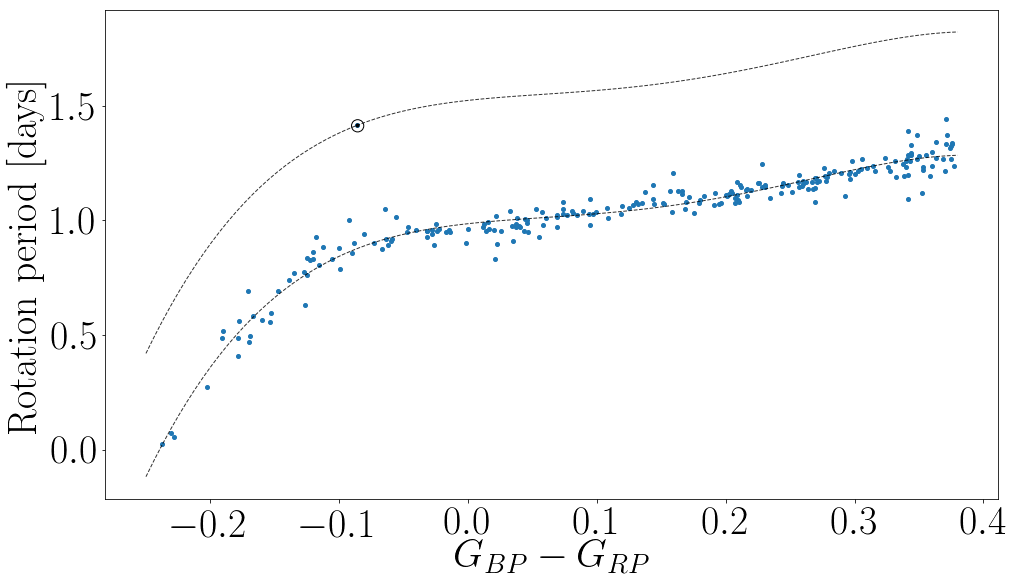

In [163]:
plt.figure(figsize=(16, 9))

plt.plot(x, y, ".", ms=8, zorder=0)
plt.plot(np.log10(sun_color), np.log10(sun_prot), ".k", zorder=0)  # Casagrande 2018
plt.scatter(np.log10(sun_color)+.0005, np.log10(sun_prot)-.002, s=150, 
            facecolors="none", edgecolors="k", zorder=0)
plt.xlabel("$G_{BP} - G_{RP}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")

xs = np.linspace(-.25, .38, 100)
plt.plot(xs, p[0] + p[1]*xs + p[2]*xs**2 + p[3]*xs**3 + p[4]*xs**4 + p[5]*np.log10(praesepe_age),
         color="k", ls="--", lw=1, zorder=0, alpha=.8)
plt.plot(xs, p[0] + p[1]*xs + p[2]*xs**2 + p[3]*xs**3 + p[4]*xs**4 + p[5]*np.log10(sun_age),
         color="k", ls="--", lw=1, zorder=0, alpha=.8)

Plotting everything together.

/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


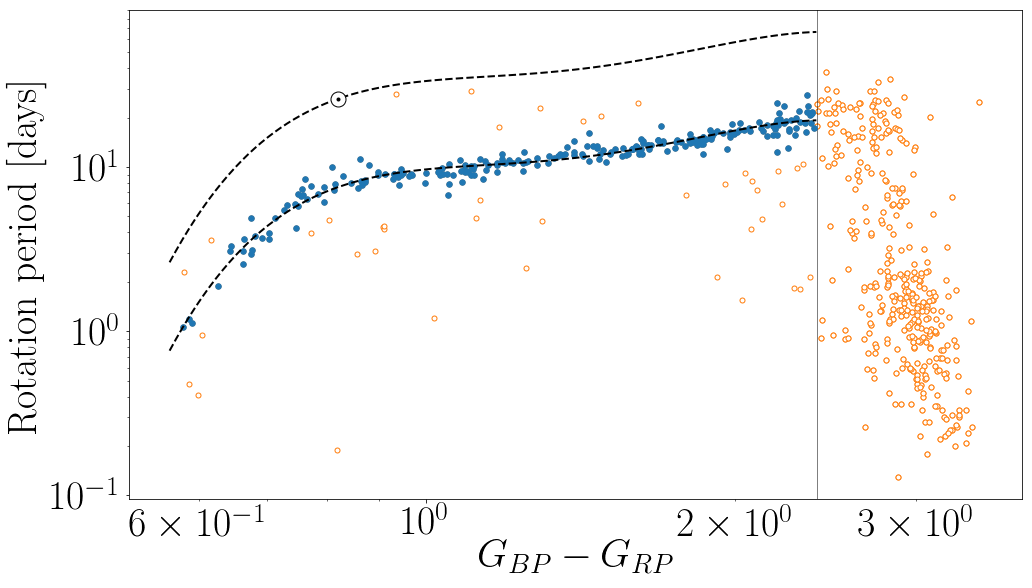

In [206]:
plt.figure(figsize=(16, 9))

# Full cluster
plt.loglog(gaia_color, df.period, "wo", ms=5, markeredgecolor="tab:orange")
plt.loglog(gaia_color[~color_mask], df.period[~color_mask], "wo", markeredgecolor="tab:orange", ms=5)
plt.axvline(Mdwarf_cut, color="k", alpha=.5, lw=1)

# Sigma clipped
plt.loglog(10**x_clipped, 10**y_clipped, ".", ms=11, color="tab:blue")

# Sun
plt.loglog(sun_color, sun_prot, "wo", markeredgecolor="k", ms=15, zorder=3)
plt.loglog(sun_color, sun_prot, ".k", zorder=3)  # Casagrande 2018

# model
plt.loglog(10**xs, 10**(p[0] + p[1]*xs + p[2]*xs**2 + p[3]*xs**3 + p[4]*xs**4 + p[5]*np.log10(praesepe_age)),
         color="k", ls="--", lw=2, zorder=2)
plt.loglog(10**xs, 10**(p[0] + p[1]*xs + p[2]*xs**2 + p[3]*xs**3 + p[4]*xs**4 + p[5]*np.log10(sun_age)),
         color="k", ls="--", lw=2, zorder=0)

# Floof
# plt.xlim(10**-.3, 10**.6)
plt.xlabel("$G_{BP} - G_{RP}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")

plt.savefig("praesepe_outliers.pdf")

Now add the angus2015 models

In [213]:
def bv_2_bprp(bv):
    """
    Numbers from https://arxiv.org/pdf/1008.0815.pdf
    """
    a, b, c, d = .0981, 1.4290, -.0269, .0061  # sigma = .43
    return a + b*bv + c*bv**2 + d*bv**3


def bprp_2_bv(bprp):
    """
    Try to find the analytic version of this, please!
    """
    bv_iter = np.linspace(0., 2., 10000)
    bprp_pred = [bv_2_bprp(bv) for bv in bv_iter]
    diffs = bprp - np.array(bprp_pred)
    return bv_iter[np.argmin(diffs**2)]


def gyro_model(log10_age, bv):
    """
    Given a B-V colour and an age, predict a rotation period.
    Returns log(age) in Myr.
    parameters:
    ----------
    logage: (array)
        The log age of a star: log10(age) in years.
    bv: (array)
        The B-V colour of a star.
    """
    age_myr = (10**log10_age)*1e-6
    
    a, b, c, n = [.4, .31, .45, .55]
    
    # return a*(age_myr)**n * (bv - c)**b
    log_P = n*np.log10(age_myr) + np.log10(a) + b*np.log10(bv-c)
    return 10**log_P

bv = np.zeros_like(xs)
for i, _x in enumerate(xs):
    bv[i] = bprp_2_bv(10**_x)
periods_praesepe = gyro_model(np.log10(625*1e6), bv)
periods_sun = gyro_model(np.log10(4.56*1e9), bv)

print(bv_2_bprp(.65))
print(bprp_2_bv(.82))

1.0172599624999998
0.5094509450945095


/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:35: RuntimeWarning: invalid value encountered in log10


Text(0,0.5,'$\\mathrm{Rotation~period~[days]}$')

/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


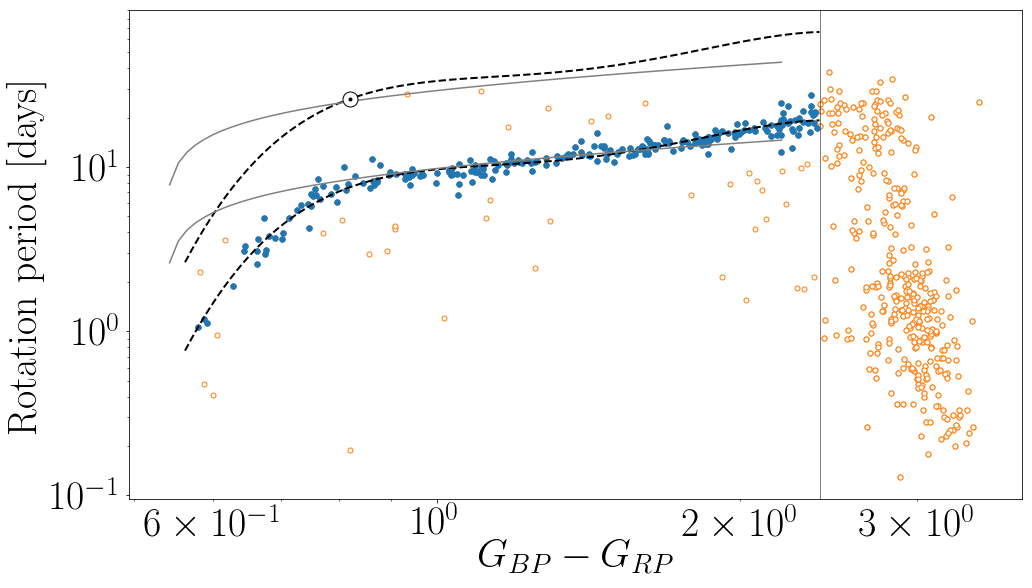

In [215]:
plt.figure(figsize=(16, 9))

# Full cluster
plt.loglog(gaia_color, df.period, "wo", ms=5, markeredgecolor="tab:orange")
plt.loglog(gaia_color[~color_mask], df.period[~color_mask], "wo", markeredgecolor="tab:orange", ms=5)
plt.axvline(Mdwarf_cut, color="k", alpha=.5, lw=1)

# Sigma clipped
plt.loglog(10**x_clipped, 10**y_clipped, ".", ms=11, color="tab:blue")

# Sun
plt.loglog(sun_color, sun_prot, "wo", markeredgecolor="k", ms=15, zorder=3)
plt.loglog(sun_color, sun_prot, ".k", zorder=3)  # Casagrande 2018

# model
plt.loglog(10**xs, 10**(p[0] + p[1]*xs + p[2]*xs**2 + p[3]*xs**3 + p[4]*xs**4 + p[5]*np.log10(praesepe_age)),
         color="k", ls="--", lw=2, zorder=2)
plt.loglog(10**xs, 10**(p[0] + p[1]*xs + p[2]*xs**2 + p[3]*xs**3 + p[4]*xs**4 + p[5]*np.log10(sun_age)),
         color="k", ls="--", lw=2, zorder=0)

plt.loglog(10**xs-.2, periods_praesepe, color=".5")
plt.loglog(10**xs-.2, periods_sun, color=".5")

# Floof
# plt.xlim(10**-.3, 10**.6)
plt.xlabel("$G_{BP} - G_{RP}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")

In [223]:
delorme = pd.read_csv("delorme_praesepe.csv", skiprows=68, delimiter=";")
delorme

,SWASP,X,Per,J-Ks,Ksmag,Vmag,Dist,pmRA,e_pmRA,pmDE,e_pmDE,Mmb,SpType,Vmagl,B-Vl,Ref,SimbadName,_RA,_DE
0,J083141.93+260641.0,,13.16,0.738,10.79,13.7,6.7,-42.8,5.6,-16.5,5.6,1.000,,,,,,127.92471,26.11139
1,J083554.98+224611.3,,9.31,0.532,10.23,12.7,3.3,-29.5,5.2,-19.5,5.2,0.928,,,,,,128.97908,22.76981
2,J083622.69+191129.3,,9.83,0.506,10.25,12.4,1.1,-39.9,6.0,-13.6,6.1,0.998,K2,12.41,1.11,12,Cl* NGC 2632 JS 127,129.09454,19.19147
3,J083627.81+175453.4,,6.91,0.315,9.40,10.9,2.0,-36.5,1.1,-11.4,1.1,0.999,F7.5,10.96,0.37,12,Cl* NGC 2632 JS 134,129.11587,17.91483
4,J083627.86+210716.2,,13.09,0.757,10.96,13.8,1.7,-36.0,1.0,-10.0,1.0,0.979,K5.9,14.04,,12,Cl* NGC 2632 JS 131,129.11608,21.12117
5,J083628.30+201342.8,,10.25,0.541,10.44,12.7,1.1,-44.3,6.3,-16.1,6.3,0.998,K1.3,12.65,0.95,15,Cl* NGC 2632 KW 535,129.11792,20.22856
6,J083648.96+191526.4,,7.41,0.396,9.68,11.3,0.9,-36.2,2.3,-12.8,1.3,1.000,G4,10.76,,11,Cl* NGC 2632 KW 539,129.20400,19.25733
7,J083657.82+213355.9,,13.27,0.834,11.12,14.1,2.0,-42.1,6.3,-12.5,6.3,1.000,K7.7,14.46,,12,Cl* NGC 2632 JS 156,129.24092,21.56553
8,J083711.48+194813.2,,8.84,0.389,9.68,11.1,0.8,-35.4,0.7,-12.8,0.7,0.977,G,11.33,0.71,13,Cl* NGC 2632 KW 23,129.29783,19.80367
9,J083718.29+194156.3,,8.90,0.373,9.80,11.6,0.7,-37.1,1.9,-15.2,1.9,0.999,G5,11.45,0.74,13,Cl* NGC 2632 KW 27,129.32621,19.69897


In [249]:
bv_delorme, period_delorme, ra_delorme, dec_delorme = [], [], [], []
for i, bv in enumerate(delorme["B-Vl"]):
    try:
        bv_delorme.append(float(bv))
        period_delorme.append(float(delorme.Per.values[i]))
        ra_delorme.append(float(delorme._RA.values[i]))
        dec_delorme.append(float(delorme._DE.values[i]))
    except:
        pass
bv_delorme, period_delorme, ra_delorme, dec_delorme = np.array(bv_delorme), \
    np.array(period_delorme), np.array(ra_delorme), np.array(dec_delorme)

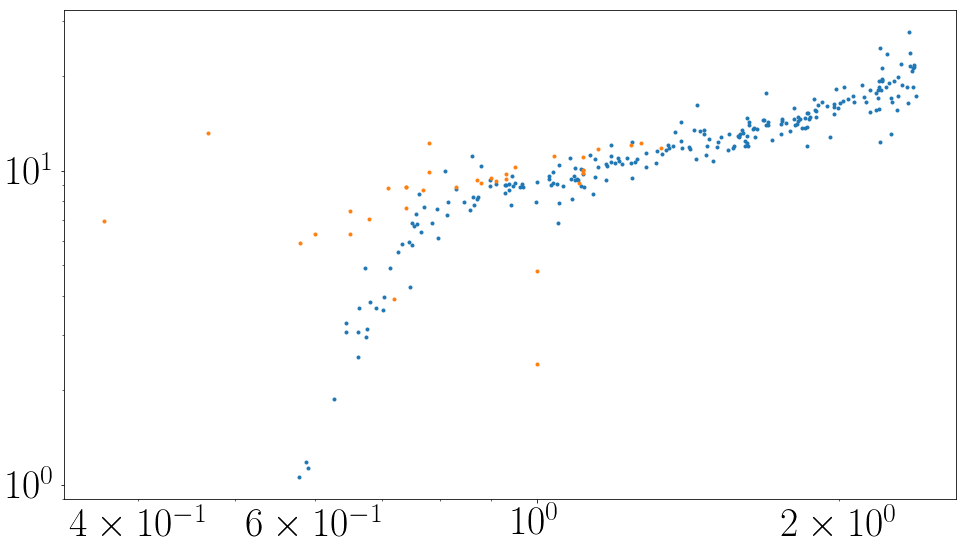

In [250]:
plt.figure(figsize=(16, 9))
plt.loglog(10**x_clipped, 10**y_clipped, ".")
plt.loglog(bv_delorme, period_delorme, ".")

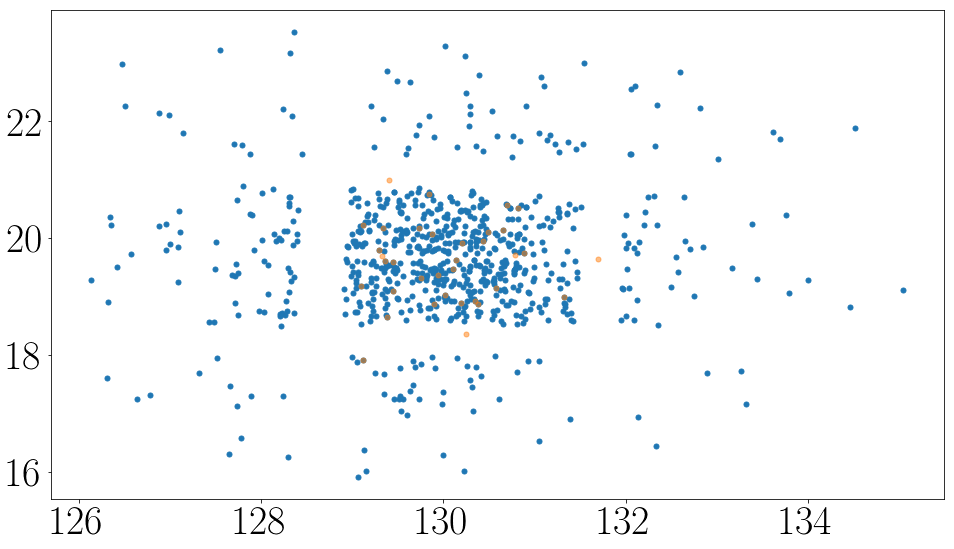

In [251]:
plt.figure(figsize=(16, 9))
plt.plot(df.ra, df.dec, ".", ms=10)
plt.plot(ra_delorme, dec_delorme, ".", alpha=.5, ms=10)

In [254]:
def find_min_dist(ra1, dec1, ra2, dec2, dist_arcsecs=5.):
    """
    ind1 is a list of indices the same length as ra1 and dec1 that identifies matching stars in ra1 and dec1.
    ind2 is a list of indices the same length as ra2 and dec2 that identifies matching stars in ra2 and dec2.
    """
    id1, id2 = np.ones((len(ra1)))*np.nan, np.ones((len(ra2)))*np.nan
    ind1, ind2 = [], []
    for i in tqdm(range(len(ra1))):
        e2 = np.sqrt((ra2 - ra1[i])**2 + (dec2 - dec1[i])**2)
        min_distance = min(e2)
        if min_distance < dist_arcsecs/3600.:
            m = e2 == min_distance
            if sum(m) > 1:  # If there is a star (a) within 5 arcsecs of this target star (i)
                m = np.arange(len(ra2))[m[0]]  # create an index mask, selecting the position of star a
            if not np.arange(len(ra2))[m] in np.array(ind2):  # If this star has not already been identified
                ind1.append(i)  # add i to the list of inds1
                ind2.append(np.arange(len(ra2))[m])  # Add a to the list of inds2
                id1[i] = i
                id2[m] = i
    
    m1, m2 = np.zeros(len(ra1), dtype="bool"), np.zeros(len(ra2), dtype="bool")
    for i in ind1:
        m1[i] = True
    for i in ind2:
        m2[i] = True
    return m1, m2, id1, id2

100%|██████████| 35/35 [00:00<00:00, 837.84it/s]


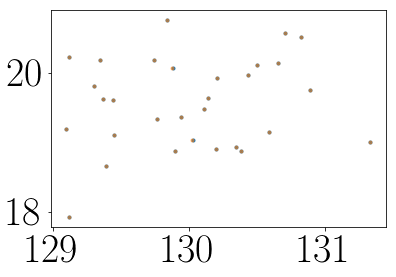

In [255]:
inds1, inds2, id1, id2 = find_min_dist(ra_delorme, dec_delorme, df.ra, df.dec)
plt.plot(ra_delorme[inds1], dec_delorme[inds1], ".")
plt.plot(df.ra[inds2], df.dec[inds2], ".", alpha=.5)

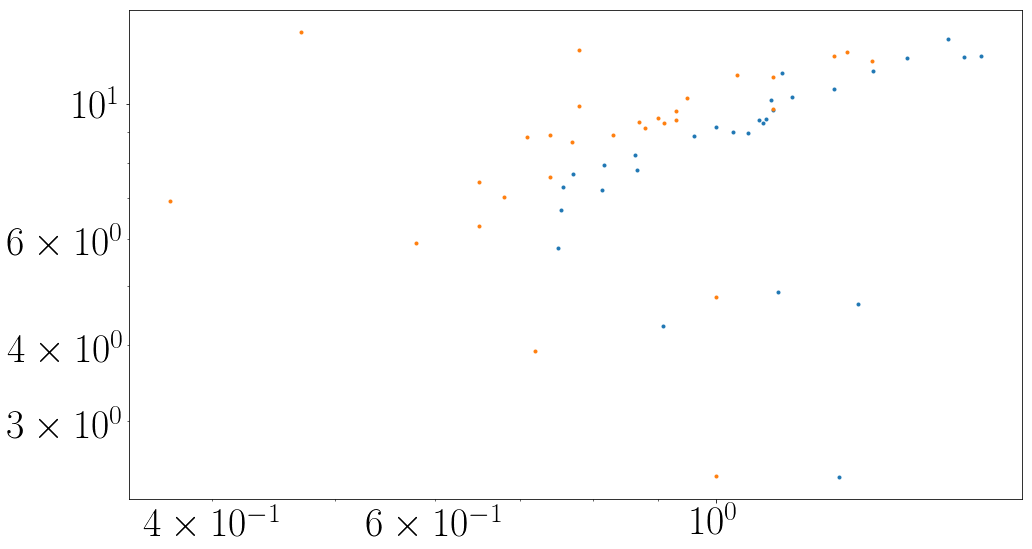

In [256]:
plt.figure(figsize=(16, 9))
plt.loglog(gaia_color[inds2], df.period[inds2], ".")
plt.loglog(bv_delorme[inds1], period_delorme[inds1], ".")

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(gaia_color[inds2], df.period[inds2], ".")
plt.loglog(bv_delorme[inds1], period_delorme[inds1], ".")